# Metagraph and Metapath Generation

Here, we use the same syntax as [HetNetPy](https://github.com/hetio/hetnetpy/tree/e1ff1f8296b766dd5a63e5870a8a1a7d82427a80) to create a metagraph and extract metapaths from the KG.

Metagraph creation is based on [this notebook](https://github.com/dhimmel/integrate/blob/93feba1765fbcd76fd79e22f25121f5399629148/integrate.ipynb).

In [1]:
import pandas as pd
import seaborn as sns
import os.path as osp

import hetnetpy.hetnet
import hetnetpy.readwrite
import hetnetpy.stats

from hetnetpy.abbreviation import metaedges_from_metapath
import re
import json
from collections import Counter

%matplotlib inline

### Define and Instantiate Metagraph:

In [2]:
kind_to_abbev = {
    
    # metanodes
    'Compound': 'C',
    'Gene': 'G',
    'Disease': 'D',
    
    # metaedges
    'upregulates': 'u',
    'downregulates': 'd',
    'activates': 'a',
    'inhibits': 'i',
    'participates': 'p',
    'treats': 't',
}

metaedge_tuples = [
    ('Compound', 'Gene', 'upregulates', 'forward'),
    ('Compound', 'Gene', 'downregulates', 'forward'),
    ('Gene', 'Gene', 'activates', 'forward'),
    ('Gene', 'Gene', 'inhibits', 'forward'),
    ('Gene', 'Disease', 'participates', 'forward'),
    ('Compound', 'Disease', 'treats', 'forward')
]

metagraph = hetnetpy.hetnet.MetaGraph.from_edge_tuples(metaedge_tuples, kind_to_abbev)
graph = hetnetpy.hetnet.Graph(metagraph)

Load in the drug-disease KG:

In [3]:
KG_DIR = '../data/kg/'
DISEASE_DIR = osp.join(KG_DIR, 'drug-disease')
SPLITS_DIR = osp.join(DISEASE_DIR, 'splits')

kg_w_train = pd.read_csv(osp.join(DISEASE_DIR, 'train.tsv', ), sep='\t', header=None)
test = pd.read_csv(osp.join(DISEASE_DIR, 'test.tsv', ), sep='\t', header=None)
val = pd.read_csv(osp.join(DISEASE_DIR, 'val.tsv', ), sep='\t', header=None)

Are there any duplicates present?

In [4]:
print(len(kg_w_train))

kg_w_train.drop_duplicates(inplace=True, subset=[0, 1, 2])

print(len(kg_w_train))

51207
50958


Also get rid of duplicates between source and target nodes:

In [5]:
print(len(kg_w_train))

kg_w_train.drop_duplicates(inplace=True, subset=[0, 2])

print(len(kg_w_train))

50958
49519


In [6]:
print(len(test))

test.drop_duplicates(inplace=True)

print(len(test))

516
516


In [7]:
# get all of the duplicates between the 0 and 2 columns
dupes = test[test.duplicated(subset=[0, 2], keep=False)]

dupes

,0,1,2


In [8]:
print(len(val))

val.drop_duplicates(inplace=True)

print(len(val))

515
515


In [9]:
# get all of the duplicates between the 0 and 2 columns
dupes = val[val.duplicated(subset=[0, 2], keep=False)]

dupes

,0,1,2


Add in some column names, node types, and adjust edge types:

In [10]:
edge_type_mapping = {('Compound', 'Gene', 'activates'): 'upregulates',
    ('Compound', 'Gene', 'inhibits'): 'downregulates',
    ('Gene', 'Gene', 'activates'): 'activates',
    ('Gene', 'Gene', 'inhibits'): 'inhibits',
    ('Gene', 'Disease', 'activates'): 'participates',
    ('Compound', 'Disease', 'treats'): 'treats'}

In [11]:
def fix_df(df):
    """Fixes the dataframe to the format we want"""
    df.columns = ['source', 'edge_type', 'target']

    src_types = []
    tgt_types = []
    edge_types = []

    for i, row in df.iterrows():
        if 'PUBCHEM.COMPOUND' in row['source']:
            src_type = 'Compound'
        elif 'NCBIGENE' in row['source']:
            src_type = 'Gene'
        elif 'DOID' in row['source']:
            src_type = 'Disease'

        src_types.append(src_type)

        if 'PUBCHEM.COMPOUND' in row['target']:
            tgt_type = 'Compound'
        elif 'NCBIGENE' in row['target']:
            tgt_type = 'Gene'
        elif 'DOID' in row['target']:
            tgt_type = 'Disease'
        
        tgt_types.append(tgt_type)

        edge_types.append(edge_type_mapping[(src_type, tgt_type, row['edge_type'])])

    df['source_node_type'] = src_types
    df['target_node_type'] = tgt_types
    df['edge_type'] = edge_types

    return df

In [12]:
kg_w_train = fix_df(kg_w_train)

Did it work?

In [13]:
kg_w_train['edge_type'].value_counts()

edge_type
activates        28542
inhibits          9518
treats            4108
upregulates       3450
downregulates     3373
participates       528
Name: count, dtype: int64

Do it for the other two dataframes too:

In [14]:
val = fix_df(val)
test = fix_df(test)

In [15]:
val['edge_type'].value_counts()

edge_type
treats    515
Name: count, dtype: int64

In [16]:
test['edge_type'].value_counts()

edge_type
treats    516
Name: count, dtype: int64

Make a version of the main KG without drug-disease edgess:

In [17]:
kg = kg_w_train.loc[kg_w_train['edge_type'] != 'treats']
train = kg_w_train.loc[kg_w_train['edge_type'] == 'treats']

In [18]:
kg['edge_type'].value_counts()

edge_type
activates        28542
inhibits          9518
upregulates       3450
downregulates     3373
participates       528
Name: count, dtype: int64

In [19]:
seen = set()

for i, row in kg.iterrows():
    if not row['source'] in seen:
        graph.add_node(kind=row['source_node_type'], identifier=row['source'])
        seen.add(row['source'])
    if not row['target'] in seen:
        graph.add_node(kind=row['target_node_type'], identifier=row['target'])
        seen.add(row['target'])

    src_id = row['source_node_type'], row['source']
    trgt_id = row['target_node_type'], row['target']

    graph.add_edge(source_id=src_id, target_id=trgt_id, kind=row['edge_type'], direction='forward')

## Network Visualization and Stats

In [20]:
metanode_df = hetnetpy.stats.get_metanode_df(graph)
metanode_df

,metanode,abbreviation,metaedges,nodes,unconnected_nodes
0,Compound,C,3,610,0
2,Disease,D,2,264,0
1,Gene,G,5,5136,0


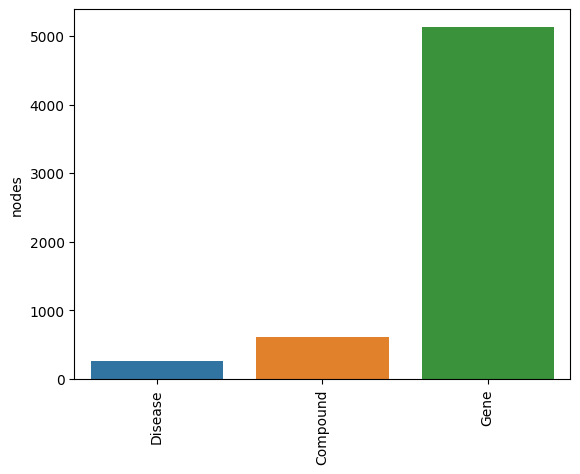

In [21]:
ax = sns.barplot(x='metanode', y='nodes', data=metanode_df.sort_values('nodes'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('nodes');

In [22]:
# Total number of nodes
metanode_df.nodes.sum()

6010

In [23]:
# Summary of metaedges and cooresponding edges
metaedge_df = hetnetpy.stats.get_metaedge_df(graph)

metaedge_df

,metaedge,abbreviation,edges,source_nodes,target_nodes
1,Compound > downregulates > Gene,Cd>G,3373,529,1187
5,Compound > treats > Disease,Ct>D,0,0,0
0,Compound > upregulates > Gene,Cu>G,3450,427,1243
2,Gene > activates > Gene,Ga>G,28542,1632,2535
3,Gene > inhibits > Gene,Gi>G,9518,852,1220
4,Gene > participates > Disease,Gp>D,528,354,264


In [24]:
metaedge_df.to_excel('../paper_materials/metaedge_df.xlsx')

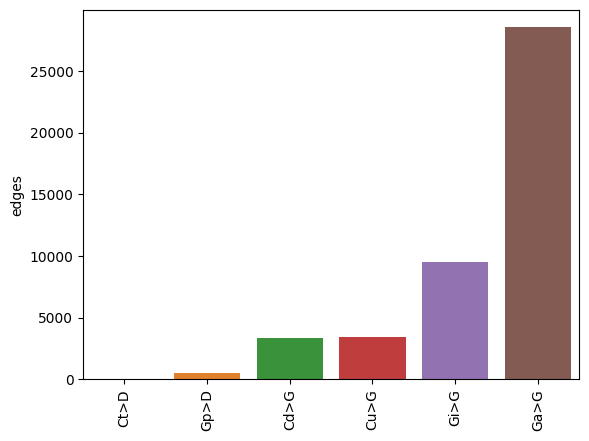

In [25]:
ax = sns.barplot(x='abbreviation', y='edges', data=metaedge_df.sort_values('edges'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('edges');

In [26]:
# Summary of different styles for representing each metaedge
metaedge_style_df = hetnetpy.stats.get_metaedge_style_df(metagraph)
metaedge_style_df

,metaedge,unicode_metaedge,standard_metaedge,abbreviation,standard_abbreviation,source,target,inverted
2,Compound > downregulates > Gene,Compound→downregulates→Gene,Compound > downregulates > Gene,Cd>G,CdG,Compound,Gene,0
10,Compound > treats > Disease,Compound→treats→Disease,Compound > treats > Disease,Ct>D,CtD,Compound,Disease,0
0,Compound > upregulates > Gene,Compound→upregulates→Gene,Compound > upregulates > Gene,Cu>G,CuG,Compound,Gene,0
9,Disease < participates < Gene,Disease←participates←Gene,Gene > participates > Disease,D<pG,GpD,Disease,Gene,1
11,Disease < treats < Compound,Disease←treats←Compound,Compound > treats > Disease,D<tC,CtD,Disease,Compound,1
5,Gene < activates < Gene,Gene←activates←Gene,Gene > activates > Gene,G<aG,GaG,Gene,Gene,1
3,Gene < downregulates < Compound,Gene←downregulates←Compound,Compound > downregulates > Gene,G<dC,CdG,Gene,Compound,1
7,Gene < inhibits < Gene,Gene←inhibits←Gene,Gene > inhibits > Gene,G<iG,GiG,Gene,Gene,1
1,Gene < upregulates < Compound,Gene←upregulates←Compound,Compound > upregulates > Gene,G<uC,CuG,Gene,Compound,1
4,Gene > activates > Gene,Gene→activates→Gene,Gene > activates > Gene,Ga>G,GaG,Gene,Gene,0


In [27]:
# Number of edges in the network
metaedge_df.edges.sum()

45411

## Metapath Extraction

Here, we have functions which can extract metapaths:

Extract metapaths from a given source node type (and, optionally, to a target node type):

In [28]:
tgt_metapaths = metagraph.extract_metapaths(source='Compound', target='Disease')
print(tgt_metapaths)

[Ct>D, Cd>Gp>D, Cu>Gp>D, Ct>D<tCt>D, Ct>D<pGp>D, Cd>G<dCt>D, Cd>G<uCt>D, Cd>G<aGp>D, Cd>Ga>Gp>D, Cd>G<iGp>D, Cd>Gi>Gp>D, Cu>G<dCt>D, Cu>G<uCt>D, Cu>G<aGp>D, Cu>Ga>Gp>D, Cu>G<iGp>D, Cu>Gi>Gp>D, Ct>D<tCd>Gp>D, Ct>D<tCu>Gp>D, Ct>D<pG<dCt>D, Ct>D<pG<uCt>D, Ct>D<pG<aGp>D, Ct>D<pGa>Gp>D, Ct>D<pG<iGp>D, Ct>D<pGi>Gp>D, Cd>G<dCd>Gp>D, Cd>G<dCu>Gp>D, Cd>G<uCd>Gp>D, Cd>G<uCu>Gp>D, Cd>Gp>D<tCt>D, Cd>Gp>D<pGp>D, Cd>G<aG<dCt>D, Cd>G<aG<uCt>D, Cd>G<aG<aGp>D, Cd>G<aGa>Gp>D, Cd>G<aG<iGp>D, Cd>G<aGi>Gp>D, Cd>Ga>G<dCt>D, Cd>Ga>G<uCt>D, Cd>Ga>G<aGp>D, Cd>Ga>Ga>Gp>D, Cd>Ga>G<iGp>D, Cd>Ga>Gi>Gp>D, Cd>G<iG<dCt>D, Cd>G<iG<uCt>D, Cd>G<iG<aGp>D, Cd>G<iGa>Gp>D, Cd>G<iG<iGp>D, Cd>G<iGi>Gp>D, Cd>Gi>G<dCt>D, Cd>Gi>G<uCt>D, Cd>Gi>G<aGp>D, Cd>Gi>Ga>Gp>D, Cd>Gi>G<iGp>D, Cd>Gi>Gi>Gp>D, Cu>G<dCd>Gp>D, Cu>G<dCu>Gp>D, Cu>G<uCd>Gp>D, Cu>G<uCu>Gp>D, Cu>Gp>D<tCt>D, Cu>Gp>D<pGp>D, Cu>G<aG<dCt>D, Cu>G<aG<uCt>D, Cu>G<aG<aGp>D, Cu>G<aGa>Gp>D, Cu>G<aG<iGp>D, Cu>G<aGi>Gp>D, Cu>Ga>G<dCt>D, Cu>Ga>G<uCt>D, Cu>Ga>G<aGp>D, Cu>Ga>Ga>Gp>

In [29]:
for i in tgt_metapaths:
    print(i)

Ct>D
Cd>Gp>D
Cu>Gp>D
Ct>D<tCt>D
Ct>D<pGp>D
Cd>G<dCt>D
Cd>G<uCt>D
Cd>G<aGp>D
Cd>Ga>Gp>D
Cd>G<iGp>D
Cd>Gi>Gp>D
Cu>G<dCt>D
Cu>G<uCt>D
Cu>G<aGp>D
Cu>Ga>Gp>D
Cu>G<iGp>D
Cu>Gi>Gp>D
Ct>D<tCd>Gp>D
Ct>D<tCu>Gp>D
Ct>D<pG<dCt>D
Ct>D<pG<uCt>D
Ct>D<pG<aGp>D
Ct>D<pGa>Gp>D
Ct>D<pG<iGp>D
Ct>D<pGi>Gp>D
Cd>G<dCd>Gp>D
Cd>G<dCu>Gp>D
Cd>G<uCd>Gp>D
Cd>G<uCu>Gp>D
Cd>Gp>D<tCt>D
Cd>Gp>D<pGp>D
Cd>G<aG<dCt>D
Cd>G<aG<uCt>D
Cd>G<aG<aGp>D
Cd>G<aGa>Gp>D
Cd>G<aG<iGp>D
Cd>G<aGi>Gp>D
Cd>Ga>G<dCt>D
Cd>Ga>G<uCt>D
Cd>Ga>G<aGp>D
Cd>Ga>Ga>Gp>D
Cd>Ga>G<iGp>D
Cd>Ga>Gi>Gp>D
Cd>G<iG<dCt>D
Cd>G<iG<uCt>D
Cd>G<iG<aGp>D
Cd>G<iGa>Gp>D
Cd>G<iG<iGp>D
Cd>G<iGi>Gp>D
Cd>Gi>G<dCt>D
Cd>Gi>G<uCt>D
Cd>Gi>G<aGp>D
Cd>Gi>Ga>Gp>D
Cd>Gi>G<iGp>D
Cd>Gi>Gi>Gp>D
Cu>G<dCd>Gp>D
Cu>G<dCu>Gp>D
Cu>G<uCd>Gp>D
Cu>G<uCu>Gp>D
Cu>Gp>D<tCt>D
Cu>Gp>D<pGp>D
Cu>G<aG<dCt>D
Cu>G<aG<uCt>D
Cu>G<aG<aGp>D
Cu>G<aGa>Gp>D
Cu>G<aG<iGp>D
Cu>G<aGi>Gp>D
Cu>Ga>G<dCt>D
Cu>Ga>G<uCt>D
Cu>Ga>G<aGp>D
Cu>Ga>Ga>Gp>D
Cu>Ga>G<iGp>D
Cu>Ga>Gi>Gp>D
Cu>G<iG<dCt>D
Cu>G<iG<uCt>D
Cu>G<iG<aGp>D

We do not want any with a compound in the middle:

In [30]:
tgt_metapaths

[Ct>D,
 Cd>Gp>D,
 Cu>Gp>D,
 Ct>D<tCt>D,
 Ct>D<pGp>D,
 Cd>G<dCt>D,
 Cd>G<uCt>D,
 Cd>G<aGp>D,
 Cd>Ga>Gp>D,
 Cd>G<iGp>D,
 Cd>Gi>Gp>D,
 Cu>G<dCt>D,
 Cu>G<uCt>D,
 Cu>G<aGp>D,
 Cu>Ga>Gp>D,
 Cu>G<iGp>D,
 Cu>Gi>Gp>D,
 Ct>D<tCd>Gp>D,
 Ct>D<tCu>Gp>D,
 Ct>D<pG<dCt>D,
 Ct>D<pG<uCt>D,
 Ct>D<pG<aGp>D,
 Ct>D<pGa>Gp>D,
 Ct>D<pG<iGp>D,
 Ct>D<pGi>Gp>D,
 Cd>G<dCd>Gp>D,
 Cd>G<dCu>Gp>D,
 Cd>G<uCd>Gp>D,
 Cd>G<uCu>Gp>D,
 Cd>Gp>D<tCt>D,
 Cd>Gp>D<pGp>D,
 Cd>G<aG<dCt>D,
 Cd>G<aG<uCt>D,
 Cd>G<aG<aGp>D,
 Cd>G<aGa>Gp>D,
 Cd>G<aG<iGp>D,
 Cd>G<aGi>Gp>D,
 Cd>Ga>G<dCt>D,
 Cd>Ga>G<uCt>D,
 Cd>Ga>G<aGp>D,
 Cd>Ga>Ga>Gp>D,
 Cd>Ga>G<iGp>D,
 Cd>Ga>Gi>Gp>D,
 Cd>G<iG<dCt>D,
 Cd>G<iG<uCt>D,
 Cd>G<iG<aGp>D,
 Cd>G<iGa>Gp>D,
 Cd>G<iG<iGp>D,
 Cd>G<iGi>Gp>D,
 Cd>Gi>G<dCt>D,
 Cd>Gi>G<uCt>D,
 Cd>Gi>G<aGp>D,
 Cd>Gi>Ga>Gp>D,
 Cd>Gi>G<iGp>D,
 Cd>Gi>Gi>Gp>D,
 Cu>G<dCd>Gp>D,
 Cu>G<dCu>Gp>D,
 Cu>G<uCd>Gp>D,
 Cu>G<uCu>Gp>D,
 Cu>Gp>D<tCt>D,
 Cu>Gp>D<pGp>D,
 Cu>G<aG<dCt>D,
 Cu>G<aG<uCt>D,
 Cu>G<aG<aGp>D,
 Cu>G<aGa>Gp>D,
 Cu>G<aG<iGp>D,
 Cu>G<a

In [31]:
CtoD_metapaths = []


for i in tgt_metapaths:
    if (repr(i) != 'Ct>D') & (Counter(re.split('>|<|[^A-Z]', repr(i)))['C'] == 1) & (Counter(re.split('>|<|[^A-Z]', repr(i)))['D'] == 1):
        CtoD_metapaths.append(i)

How many did it prune?

In [32]:
print(len(CtoD_metapaths))
print(len(tgt_metapaths))

42
85


In [33]:
CtoD_metapaths

[Cd>Gp>D,
 Cu>Gp>D,
 Cd>G<aGp>D,
 Cd>Ga>Gp>D,
 Cd>G<iGp>D,
 Cd>Gi>Gp>D,
 Cu>G<aGp>D,
 Cu>Ga>Gp>D,
 Cu>G<iGp>D,
 Cu>Gi>Gp>D,
 Cd>G<aG<aGp>D,
 Cd>G<aGa>Gp>D,
 Cd>G<aG<iGp>D,
 Cd>G<aGi>Gp>D,
 Cd>Ga>G<aGp>D,
 Cd>Ga>Ga>Gp>D,
 Cd>Ga>G<iGp>D,
 Cd>Ga>Gi>Gp>D,
 Cd>G<iG<aGp>D,
 Cd>G<iGa>Gp>D,
 Cd>G<iG<iGp>D,
 Cd>G<iGi>Gp>D,
 Cd>Gi>G<aGp>D,
 Cd>Gi>Ga>Gp>D,
 Cd>Gi>G<iGp>D,
 Cd>Gi>Gi>Gp>D,
 Cu>G<aG<aGp>D,
 Cu>G<aGa>Gp>D,
 Cu>G<aG<iGp>D,
 Cu>G<aGi>Gp>D,
 Cu>Ga>G<aGp>D,
 Cu>Ga>Ga>Gp>D,
 Cu>Ga>G<iGp>D,
 Cu>Ga>Gi>Gp>D,
 Cu>G<iG<aGp>D,
 Cu>G<iGa>Gp>D,
 Cu>G<iG<iGp>D,
 Cu>G<iGi>Gp>D,
 Cu>Gi>G<aGp>D,
 Cu>Gi>Ga>Gp>D,
 Cu>Gi>G<iGp>D,
 Cu>Gi>Gi>Gp>D]

# PoLo Input Preparation

What if we want to get these in a format similar to the PoLo output?

First let's give them all a uniform probability:

In [34]:
#prob = 1 / (2 * len(CtoD_metapaths))
prob = 0.5

We can split the metapaths into a series of individual relations:

In [35]:
def get_forward_rule_body(mpath, conf, metagraph):
    """Gets the rule body for a given metapath in the format that PoLo requires
        :param mpath: the metapath instance, written in hetnetpy format
        :param conf: the confidence value to use for the rule
        :param metagraph: the metagraph instance, as a hetnetpy object
    """
    st_edges = metaedges_from_metapath(mpath, standardize_by=metagraph)
    directional_edges = metaedges_from_metapath(mpath)
    rule_head = re.split('>|<|[^A-Z]', mpath)
    rule_head = rule_head[0] + 't' + rule_head[-1]
    rule_body = [conf, rule_head]
    for st, dic in zip(st_edges, directional_edges):
        if '>' in dic:
            rule_body.append(st)
        else:
            rule_body.append('_' + st)
    return rule_body

In [36]:
# just testing the function
get_forward_rule_body('Cu>G<uCd>Gp>D', prob, metagraph)

[0.5, 'CtD', 'CuG', '_CuG', 'CdG', 'GpD']

In [37]:
def get_reverse_rule_body(forward_body):
    """Gets the REVERSE rule body for a given metapath in the format that PoLo requires
        :param forward_body: the forward rule body as a list
    """
    rev_body = [forward_body[0], '_' + forward_body[1]]
    for i in reversed(forward_body[2:]):
        if '_' in i:
            rev_body.append(re.sub('_', '', i))
        else:
            rev_body.append('_' + i)
    return rev_body

In [38]:
fw = get_forward_rule_body('Cu>G<uCd>Gp>D', prob, metagraph)
get_reverse_rule_body(fw)

[0.5, '_CtD', '_GpD', '_CdG', 'CuG', '_CuG']

Now we'll do it for all the compound to D metapaths!

In [39]:
rules = {}
rules['CtD'] = [get_forward_rule_body(str(mpath), prob, metagraph) for mpath in CtoD_metapaths]
#rules['_CtD'] = [get_reverse_rule_body(mpath) for mpath in rules['CtD']]
print(rules)

{'CtD': [[0.5, 'CtD', 'CdG', 'GpD'], [0.5, 'CtD', 'CuG', 'GpD'], [0.5, 'CtD', 'CdG', '_GaG', 'GpD'], [0.5, 'CtD', 'CdG', 'GaG', 'GpD'], [0.5, 'CtD', 'CdG', '_GiG', 'GpD'], [0.5, 'CtD', 'CdG', 'GiG', 'GpD'], [0.5, 'CtD', 'CuG', '_GaG', 'GpD'], [0.5, 'CtD', 'CuG', 'GaG', 'GpD'], [0.5, 'CtD', 'CuG', '_GiG', 'GpD'], [0.5, 'CtD', 'CuG', 'GiG', 'GpD'], [0.5, 'CtD', 'CdG', '_GaG', '_GaG', 'GpD'], [0.5, 'CtD', 'CdG', '_GaG', 'GaG', 'GpD'], [0.5, 'CtD', 'CdG', '_GaG', '_GiG', 'GpD'], [0.5, 'CtD', 'CdG', '_GaG', 'GiG', 'GpD'], [0.5, 'CtD', 'CdG', 'GaG', '_GaG', 'GpD'], [0.5, 'CtD', 'CdG', 'GaG', 'GaG', 'GpD'], [0.5, 'CtD', 'CdG', 'GaG', '_GiG', 'GpD'], [0.5, 'CtD', 'CdG', 'GaG', 'GiG', 'GpD'], [0.5, 'CtD', 'CdG', '_GiG', '_GaG', 'GpD'], [0.5, 'CtD', 'CdG', '_GiG', 'GaG', 'GpD'], [0.5, 'CtD', 'CdG', '_GiG', '_GiG', 'GpD'], [0.5, 'CtD', 'CdG', '_GiG', 'GiG', 'GpD'], [0.5, 'CtD', 'CdG', 'GiG', '_GaG', 'GpD'], [0.5, 'CtD', 'CdG', 'GiG', 'GaG', 'GpD'], [0.5, 'CtD', 'CdG', 'GiG', '_GiG', 'GpD'], [0.5,

In [40]:
rules.keys()

dict_keys(['CtD'])

Finally, the rules have different lengths. Let's make it so that the smaller ones could also be used as longer rules by using the padding token "NO_OP", which means that the agent has decided to stay at the node.

In [41]:
def expand_rule(rule):
    """Expands a rule by a length of 1 to another series of rules by putting NO_OP in every gap"""
    new_rules = []
    for i in range(2, len(rule)):
        if rule[i] != 'NO_OP':
            new_rule = rule[0:i] + ['NO_OP'] + rule[i:]
            new_rules.append(new_rule)
    new_rules.append(rule + ['NO_OP'])
    return new_rules


In [42]:
expand_rule([0.5, 'CtD', 'CdG', 'GpD'])

[[0.5, 'CtD', 'NO_OP', 'CdG', 'GpD'],
 [0.5, 'CtD', 'CdG', 'NO_OP', 'GpD'],
 [0.5, 'CtD', 'CdG', 'GpD', 'NO_OP']]

In [43]:
expand_rule([0.5, 'CtD', 'CuG', 'GpD', 'NO_OP'])

[[0.5, 'CtD', 'NO_OP', 'CuG', 'GpD', 'NO_OP'],
 [0.5, 'CtD', 'CuG', 'NO_OP', 'GpD', 'NO_OP'],
 [0.5, 'CtD', 'CuG', 'GpD', 'NO_OP', 'NO_OP']]

In [44]:
expand_rule([0.5, 'CtD', 'CuG', 'NO_OP', 'GpD'])

[[0.5, 'CtD', 'NO_OP', 'CuG', 'NO_OP', 'GpD'],
 [0.5, 'CtD', 'CuG', 'NO_OP', 'NO_OP', 'GpD'],
 [0.5, 'CtD', 'CuG', 'NO_OP', 'GpD', 'NO_OP']]

In [45]:
for key in rules.keys():
    for path in rules[key]:
        if len(path) - 2 == 2:
            rules[key].extend(expand_rule(path))

for key in rules.keys():
    for path in rules[key]:
        if len(path) - 2 == 3:
            rules[key].extend(expand_rule(path))

Let's write it to a file we can use for PoLo:

In [46]:
with open(osp.join(SPLITS_DIR, 'rules.txt'), 'w') as f:
    json.dump(rules, f)

Now, let's get the input triples in a format consistent with PoLo's input files:

In [47]:
def convert_to_polo(df):
    """Converts the KG into a format that PoLo can use
    """
    df['metaedge'] = [kind_to_abbev[row['source_node_type']] + kind_to_abbev[row['edge_type']] + \
                       kind_to_abbev[row['target_node_type']] for i, row in df.iterrows()]
    return df[['source', 'metaedge', 'target']]

In [48]:
train = convert_to_polo(train)
test = convert_to_polo(test)
val = convert_to_polo(val)

kg_triples = convert_to_polo(kg_w_train)

/var/folders/dz/hsmx5qv534b8zxlrfdjxfn9h0000gn/T/ipykernel_25986/1543363494.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['metaedge'] = [kind_to_abbev[row['source_node_type']] + kind_to_abbev[row['edge_type']] + \


In [49]:
kg_triples

,source,metaedge,target
0,PUBCHEM.COMPOUND:33741,CtD,DOID:1540
1,PUBCHEM.COMPOUND:4595,CtD,DOID:0060058
2,PUBCHEM.COMPOUND:31401,CtD,DOID:13580
3,PUBCHEM.COMPOUND:30751,CtD,DOID:1793
4,PUBCHEM.COMPOUND:5284616,CtD,DOID:3721
...,...,...,...
51202,NCBIGENE:999,GiG,NCBIGENE:3480
51203,NCBIGENE:999,GiG,NCBIGENE:4233
51204,NCBIGENE:999,GiG,NCBIGENE:5594
51205,NCBIGENE:999,GiG,NCBIGENE:5595


Get the inverse triples of the KG:

In [50]:
inverse_triples = kg_triples[['source', 'target', 'metaedge']].copy()
inverse_triples['inv_metaedge'] = ['_' + i for i in inverse_triples['metaedge']]
inverse_triples = inverse_triples[['target', 'inv_metaedge', 'source']]

# get rid of those with _CtD
inverse_triples = inverse_triples.loc[inverse_triples['inv_metaedge'] != '_CtD']

Great, write to the PoLo folder:

In [51]:
kg_triples.to_csv(osp.join(SPLITS_DIR, 'graph_triples.txt'), sep='\t', index=False, header=False)
inverse_triples.to_csv(osp.join(SPLITS_DIR, 'graph_inverses.txt'), sep='\t', index=False, header=False)

In [52]:
train.to_csv(osp.join(SPLITS_DIR, 'train.txt'), sep='\t', index=False, header=False)
test.to_csv(osp.join(SPLITS_DIR, 'test.txt'), sep='\t', index=False, header=False)
val.to_csv(osp.join(SPLITS_DIR, 'dev.txt'), sep='\t', index=False, header=False)

Finally, we need dictionaries to map the entities and relations to unique IDs.

In [53]:
entities = {"PAD": 0, "UNK": 1}

next_id = 2
for df in kg_triples, train, test, val:
    for i in df['source'].unique():
        if i not in entities:
            entities[i] = next_id
            next_id += 1
    for i in df['target'].unique():
        if i not in entities:
            entities[i] = next_id
            next_id += 1

In [54]:
relations = {"PAD": 0, "DUMMY_START_RELATION": 1, "NO_OP": 2, "UNK": 3}

metaedges = set(kg_triples['metaedge']) | (set(inverse_triples['inv_metaedge']))

next_id = 4
for rel in metaedges:
    relations[rel] = next_id
    next_id += 1

In [55]:
# write dictionary to json file
with open(osp.join(SPLITS_DIR, 'entity_vocab.json'), 'w') as f:
    json.dump(entities, f)

with open(osp.join(SPLITS_DIR, 'relation_vocab.json'), 'w') as f:
    json.dump(relations, f)